First 5 rows of the dataset:
   Unnamed: 0  state_x  state_y move_dir throw_dir Action  move_x  move_y  \
0           0      -10      -10        1      none   MOVE       1       1   
1           1      -10       -9        1      none   MOVE       1       1   
2           2      -10       -8        1      none   MOVE       1       1   
3           3      -10       -7        1      none   MOVE       1       1   
4           4      -10       -6        1      none   MOVE       1       1   

   throw_dir_2    u    v  
0        -1000  0.1  0.1  
1        -1000  0.1  0.1  
2        -1000  0.1  0.1  
3        -1000  0.1  0.1  
4        -1000  0.1  0.1  

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1140 entries, 0 to 1139
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1140 non-null   int64  
 1   state_x      1140 non-null   int64  
 2   state_y      1140 non-null   int64  
 3   move_dir 

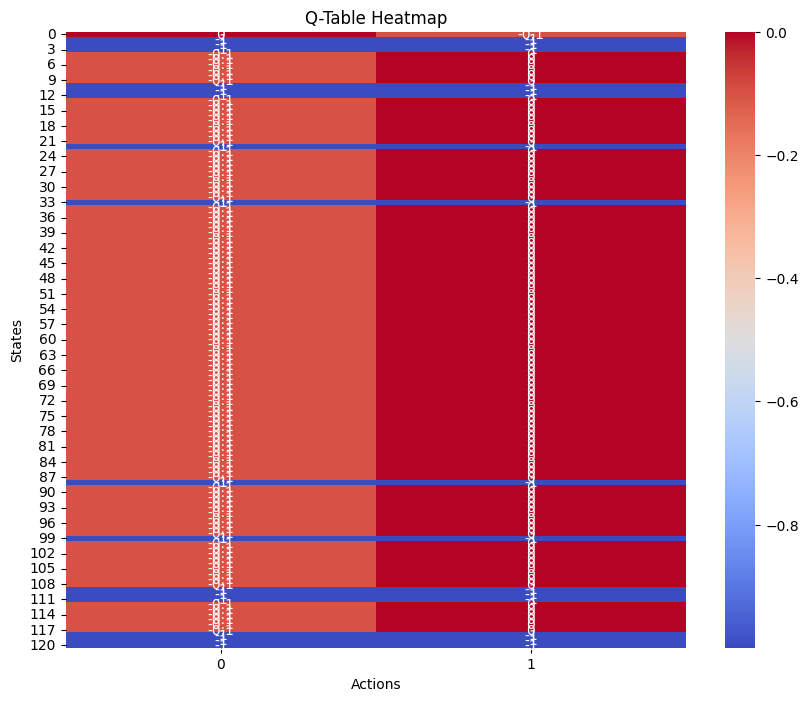

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load and inspect the dataset
optimal_policy_df = pd.read_csv('OptimalPolicy_angletol45.csv')

print("First 5 rows of the dataset:")
print(optimal_policy_df.head())

print("\nDataset Info:")
print(optimal_policy_df.info())

print("\nDataset Statistics:")
print(optimal_policy_df.describe())

# Step 2: Define the grid size based on state_x and state_y ranges
grid_size_x = optimal_policy_df['state_x'].max() + 1  # Grid size in the x-direction
grid_size_y = optimal_policy_df['state_y'].max() + 1  # Grid size in the y-direction
grid_size = (grid_size_x, grid_size_y)

# Step 3: Extract positions for the teacher and bin

# Check if there's any row where move_dir is 'teacher'
if not optimal_policy_df[optimal_policy_df['move_dir'] == 'teacher'].empty:
    teacher_position = (optimal_policy_df[optimal_policy_df['move_dir'] == 'teacher']['state_x'].iloc[0],
                        optimal_policy_df[optimal_policy_df['move_dir'] == 'teacher']['state_y'].iloc[0])
else:
    teacher_position = None
    print("No 'teacher' move direction found in the dataset.")

# Check if there's any row where throw_dir is 'bin'
if not optimal_policy_df[optimal_policy_df['throw_dir'] == 'bin'].empty:
    bin_position = (optimal_policy_df[optimal_policy_df['throw_dir'] == 'bin']['state_x'].iloc[0],
                    optimal_policy_df[optimal_policy_df['throw_dir'] == 'bin']['state_y'].iloc[0])
else:
    bin_position = None
    print("No 'bin' throw direction found in the dataset.")

# Assume students are in all other positions
students_positions = list(zip(optimal_policy_df['state_x'], optimal_policy_df['state_y']))

# Step 4: Initialize the Q-table
actions = optimal_policy_df['Action'].unique()
action_mapping = {action: idx for idx, action in enumerate(actions)}
action_size = len(actions)

# Assume state_size based on grid dimensions
state_size = grid_size_x * grid_size_y  # Example: if grid size is (5, 5)

# Initialize the Q-table
q_table = np.zeros((state_size, action_size))

print("\nAction Mapping:")
print(action_mapping)

print("\nQ-Table Initialized with shape:", q_table.shape)

# Step 5: Define helper functions for the agent

# Reward function
def get_reward(row, teacher_position, bin_position):
    if row['move_dir'] == 'teacher':
        if row['throw_dir'] == 'bin':
            return 1  # Reward for reaching the bin
        else:
            return -1  # Penalty for throwing in the wrong direction
    else:
        return -0.1  # Small penalty to encourage quicker solutions

# Function to get the next state
def get_next_state(row, grid_size):
    x, y = row['state_x'], row['state_y']
    
    if row['move_dir'] == 'up':
        return (max(x - 1, 0), y)
    elif row['move_dir'] == 'down':
        return (min(x + 1, grid_size[0] - 1), y)
    elif row['move_dir'] == 'left':
        return (x, max(y - 1, 0))
    elif row['move_dir'] == 'right':
        return (x, min(y + 1, grid_size[1] - 1))
    
    return (x, y)

# Function to update the Q-table
def update_q_table(state_index, action_index, reward, next_state_index, q_table, learning_rate, discount_factor):
    best_next_action = np.argmax(q_table[next_state_index, :])
    td_target = reward + discount_factor * q_table[next_state_index, best_next_action]
    td_error = td_target - q_table[state_index, action_index]
    q_table[state_index, action_index] += learning_rate * td_error

# Training function for the agent
def train_agent(df, q_table, action_mapping, teacher_position, bin_position, grid_size, learning_rate=0.1, discount_factor=0.9, epsilon=0.1, episodes=1000):
    for episode in range(episodes):
        for index, row in df.iterrows():
            state = (row['state_x'], row['state_y'])
            state_index = state[0] * grid_size[1] + state[1]
            action = row['Action']
            action_index = action_mapping.get(action, -1)
            if action_index == -1:
                continue
            next_state = get_next_state(row, grid_size)
            next_state_index = next_state[0] * grid_size[1] + next_state[1]
            reward = get_reward(row, teacher_position, bin_position)
            update_q_table(state_index, action_index, reward, next_state_index, q_table, learning_rate, discount_factor)
    return q_table

# Step 6: Train the agent
q_table = train_agent(optimal_policy_df, q_table, action_mapping, teacher_position, bin_position, grid_size)

# Step 7: Visualize the Q-table
plt.figure(figsize=(10, 8))
sns.heatmap(q_table, annot=True, cmap="coolwarm", cbar=True)
plt.title("Q-Table Heatmap")
plt.xlabel("Actions")
plt.ylabel("States")
plt.show()
